In [2]:
import pandas as pd
import numpy as np

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [3]:
data_df = pd.read_csv('titanic.csv')

## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
y_data = data_df[['Survived']]
y_data.head(3)

,Survived
0,0
1,1
2,1


In [5]:
del data_df['Survived']

x_data = data_df.copy()

x_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [6]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### 2-1.Name


In [7]:
# 이름 분류

data_df['name_group']=''
for x in range(len(data_df['Name'])):
    data_df['name_group'][x]=data_df['Name'][x].split(',')[1].split('.')[0]

ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
data_df['name_group'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Col               2
 Mlle              2
 Don               1
 Lady              1
 Capt              1
 Sir               1
 Mme               1
 Jonkheer          1
 Ms                1
 the Countess      1
Name: name_group, dtype: int64

In [9]:
# data_df['name_group'] = data_df['name_group'].replace(['Lady','Countess','Capt','Col',
#                                                        'Don','Dr','Major','Rev',
#                                                        'Sir', 'Jonkheer'], 'Rare')

# data_df['name_group'] = data_df['name_group'].replace('Mlle', 'Miss')
# data_df['name_group'] = data_df['name_group'].replace('Ms', 'Miss')
# data_df['name_group'] = data_df['name_group'].replace('Mme', 'Miss')

### 2-2. Sex

In [10]:
#Sex
data_df['Sex']=data_df['Sex'].replace(['male', 'female'], [0, 1])

### 2-3. Age

In [11]:
age_group_mean = data_df.groupby(['name_group'])['Age'].mean().to_dict()

# iterate through the rows with missing age data and substitue w/ avg
for passenger in data_df[data_df['Age'].isnull()].index:
    title = data_df[data_df['Age'].isnull()]['name_group'][passenger]
    data_df['Age'][passenger] = age_group_mean[title]

ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
data_df['Age'] = pd.qcut(data_df['Age'], 10)

In [13]:
data_df['Age'] = data_df['Age'].astype('category').cat.codes

In [14]:
data_df[data_df['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_group


### 2-4. SibSp&Parch --> Companion

In [15]:
count_dict = dict(data_df['Ticket'].value_counts())

In [16]:
#동행자 수를 열 값으로 갖는 새로운 'companion' 열 생성
data_df['companion'] = data_df['Ticket'].apply(lambda  x : count_dict[x])

In [17]:
#sibsp, parch 둘다 0 이고 티켓 넘버 같은 것도 없을 경우 일행 없는 것으로 간주하고 0, 나머지는 1(일행있음)
data_df['companion'] = [0 if data_df['SibSp'][x] == 0 and data_df['Parch'][x] == 0 and count_dict[data_df['Ticket'][x]] == 1 else 1 for x in data_df.index ]

### 2-5. Fare

In [18]:
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

In [19]:
data_df['Fare'] = data_df['FareBin'].astype('category').cat.codes

### 2-6. Embarked

In [20]:
data_df[data_df['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_group,companion,FareBin
61,62,1,"Icard, Miss. Amelie",1,7,0,0,113572,4,B28,NaN,Miss,1,"(39.688, 512.329]"
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,9,0,0,113572,4,B28,NaN,Mrs,1,"(39.688, 512.329]"


In [21]:
# create df based on class
class1st = data_df[data_df['Pclass'] == 1]

# find average fare of class 1 passengers
class1st_C = class1st[class1st['Embarked'] == 'C']['Fare'].mean()
class1st_S = class1st[class1st['Embarked'] == 'S']['Fare'].mean()
class1st_Q = class1st[class1st['Embarked'] == 'Q']['Fare'].mean()

In [22]:
# fill in missing data for both passengers (61 and 829) with Southampton
data_df['Embarked'][61] = 'S'
data_df['Embarked'][829] = 'S'

ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
data_df['Embarked']=data_df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2])

In [24]:
data_df[data_df['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_group,companion,FareBin


### 2-7.불필요한 열 삭제

In [25]:
data_df= data_df.drop(['PassengerId','Name','Cabin','SibSp','Parch','Ticket','FareBin','name_group'], axis=1)
data_df.head()

,Pclass,Sex,Age,Fare,Embarked,companion
0,3,0,2,0,0,1
1,1,1,7,4,1,1
2,3,1,3,1,0,0
3,1,1,7,4,0,1
4,3,0,7,1,0,0


---------------------------------------------------------------------------------------------------------------

<br>

## 3. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train,X_test,y_train,y_test = train_test_split(data_df,y_data,test_size=0.3, random_state=10)

<br>

## 4. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

In [28]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [29]:
import warnings 
warnings.filterwarnings(action='ignore')

### K-fold

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### 4-1. kNN

In [31]:
clf_kNN=KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf_kNN, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.75555556 0.78651685 0.79775281 0.74157303 0.76404494 0.79775281
 0.76404494 0.76404494 0.73033708 0.79775281]


In [32]:
round(np.mean(score)*100,2)

76.99

### 4-2. Decision Tree

In [33]:
clf_DT = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf_DT, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.80898876 0.75280899 0.75280899 0.84269663 0.82022472
 0.78651685 0.75280899 0.76404494 0.7752809 ]


In [34]:
round(np.mean(score)*100,2)

78.23

### 4-3. Random Forest

In [35]:
clf_RF = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf_RF, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.74444444 0.86516854 0.7752809  0.78651685 0.84269663 0.84269663
 0.83146067 0.76404494 0.7752809  0.80898876]


In [36]:
round(np.mean(score)*100, 2)

80.37

### 4-4. Naive Bayes

In [37]:
clf_NB = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf_NB, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.78651685 0.71910112 0.70786517 0.74157303 0.79775281
 0.7752809  0.73033708 0.80898876 0.78651685]


In [38]:
round(np.mean(score)*100, 2)

76.21

### 4-5. SVM

In [39]:
clf_SVC = SVC()
scoring = 'accuracy'
score = cross_val_score(clf_SVC, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.78888889 0.7752809  0.79775281 0.75280899 0.80898876 0.78651685
 0.78651685 0.82022472 0.82022472 0.80898876]


In [40]:
round(np.mean(score)*100, 2)

79.46

### 4-5. SVM

In [41]:
clf_LR = linear_model.LogisticRegression()
scoring = 'accuracy'
score = cross_val_score(clf_LR, data_df, y_data, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.79775281 0.78651685 0.75280899 0.7752809  0.78651685
 0.78651685 0.78651685 0.78651685 0.79775281]


<br>

## 5. Train the model

In [42]:
clf_kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [43]:
clf_DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=13)

In [45]:
clf_NB.fit(X_train, y_train)

GaussianNB()

In [46]:
clf_SVC.fit(X_train, y_train)

SVC()

In [47]:
clf_LR.fit(X_train, y_train)

LogisticRegression()

<br>

## 6. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

In [48]:
from sklearn.metrics import accuracy_score

In [49]:
predict_kNN = clf_kNN.predict(X_test)
accuracy_kNN = accuracy_score(y_test,predict_kNN)
accuracy_kNN

0.8171641791044776

In [50]:
predict_DT = clf_DT.predict(X_test)
accuracy_DT = accuracy_score(y_test,predict_DT)
accuracy_DT

0.7649253731343284

In [51]:

predict_RF = clf_RF.predict(X_test)
accuracy_RF = accuracy_score(y_test,predict_RF)
accuracy_RF

0.8059701492537313

In [52]:
predict_NB = clf_NB.predict(X_test)
accuracy_NB = accuracy_score(y_test,predict_NB)
accuracy_NB

0.8097014925373134

In [53]:
predict_SVC = clf_SVC.predict(X_test)
accuracy_SVC = accuracy_score(y_test,predict_SVC)
accuracy_SVC

0.8059701492537313

In [54]:
predict_LR = clf_LR.predict(X_test)
accuracy_LR = accuracy_score(y_test,predict_LR)
accuracy_LR

0.8208955223880597

## 시각화

In [55]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

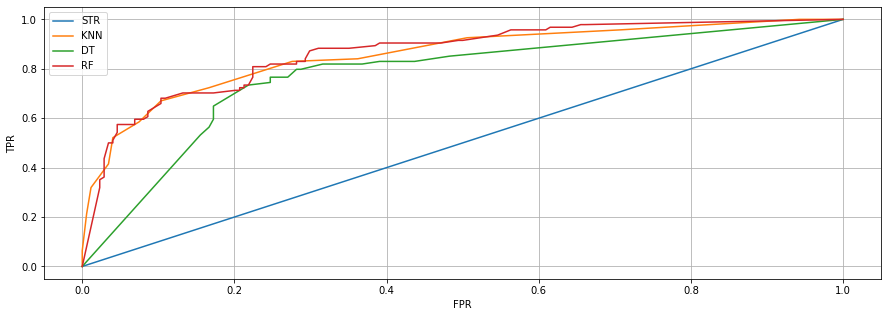

In [56]:
pred_test1 = clf_kNN.predict_proba(X_test)[:,1]
pred_test2 = clf_DT.predict_proba(X_test)[:,1]
pred_test3 = clf_RF.predict_proba(X_test)[:,1]


fprs1, tprs1, _ = roc_curve(y_test, pred_test1)
fprs2, tprs2, _ = roc_curve(y_test, pred_test2)
fprs3, tprs3, _ = roc_curve(y_test, pred_test3)

plt.figure(figsize=(15,5))

# 대각선
plt.plot([0,1],[0,1],label='STR')


# ROC
plt.plot(fprs1,tprs1,label='KNN')
plt.plot(fprs2,tprs2,label='DT')
plt.plot(fprs3,tprs3,label='RF')


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [57]:
# precisions1, recalls1, thresholds1 = roc_curve(y_test, pred_positive_label1)
# precisions2, recalls2, thresholds2 = roc_curve(y_test, pred_positive_label2)
# precisions3, recalls3, thresholds3 = roc_curve(y_test, pred_positive_label3)